In [1]:
from detector_model import NorthernTracksDetectorModel
from backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator)
from backend.operations import AssignValue, FunctionCall
from backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from backend.parameterizations import LogParameterization
from backend.expression import StringExpression
import logging
logging.basicConfig(level=logging.WARN)
import pystan
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats

#import holoviews as hv
#from holoviews import opts
#hv.extension('bokeh', "matplotlib")


# Create stan files for the detector model

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


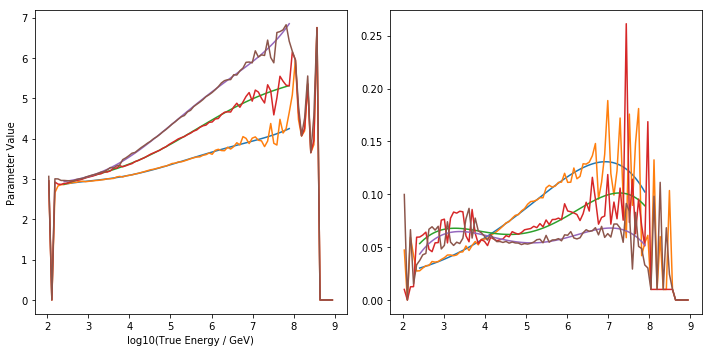

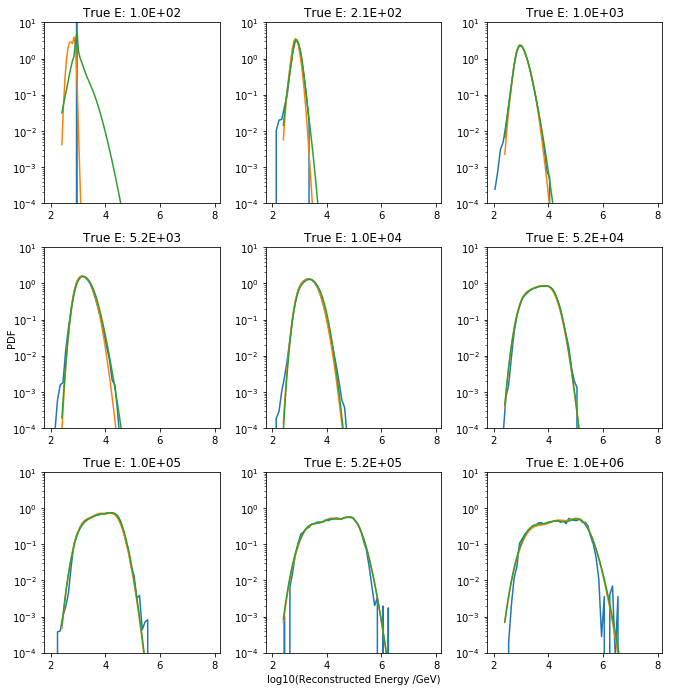

In [2]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd = NorthernTracksDetectorModel()    
    cg.generate_files()
    

# Plot detector model distributions

In [5]:
e_true_name = "e_trues"
e_reco_name = "e_recos"
true_dir_name = "true_dirs"
reco_zenith_name = "reco_zeniths"

with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        array_length = ForwardVariableDef("n", "int")
        array_length_str = ["[", array_length, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str)
        e_recos = ForwardArrayDef(e_reco_name, "real", array_length_str)
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str)
        reco_zenith = ForwardArrayDef(reco_zenith_name, "real", array_length_str)

    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        array_length_2d_str = ["[", array_length, ",", array_length, "]"]
        e_res_result = ForwardArrayDef("e_res", "real", array_length_2d_str)
        eff_area_result = ForwardArrayDef("eff_area", "real", array_length_2d_str)
        ang_res_result = ForwardArrayDef("ang_res", "real", array_length_2d_str)

        
        reco_dir_ang_res = ForwardVariableDef("reco_dir", "vector[3]")        
        true_dir_ang_res = ForwardVariableDef("true_dir", "vector[3]")
        true_dir_ang_res << StringExpression("[sin(pi()/2), 0, cos(pi()/2)]'")
        
        with ForLoopContext(1, array_length, "i") as i:
            with ForLoopContext(1, array_length, "j") as j:
                eff_area_result[i][j] << ntd.effective_area(e_trues[i], true_dirs[j])       
                e_res_result[i][j] << ntd.energy_resolution(e_trues[i], e_recos[j])
                reco_dir_ang_res << StringExpression(["[sin(", reco_zenith[j], "), 0, cos(", reco_zenith[j],")]'"])
                ang_res_result[i][j] << ntd.angular_resolution(e_trues[i], true_dir_ang_res, reco_dir_ang_res)
    model = cg.generate()

In [4]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

In [11]:
n = 100
e_reco = np.logspace(2, 9, n)
e_true = np.logspace(2, 7, n)
reco_zeniths = np.radians(np.linspace(85, 95, n))
zeniths = np.radians(np.linspace(85, 180, n, endpoint=False))
true_dir = np.asarray([np.sin(zeniths), np.zeros_like(zeniths), np.cos(zeniths)]).T

true_dir_name

data = {
    e_true_name: e_reco,
    e_reco_name: e_true,
    true_dir_name: true_dir,
    reco_zenith_name: reco_zeniths,
    "n": n
    #"reco_dir": dir2
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


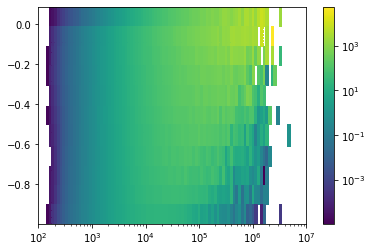

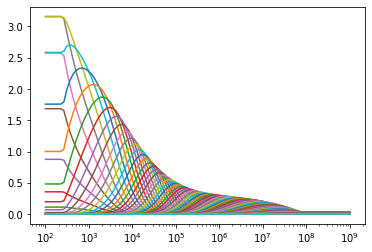

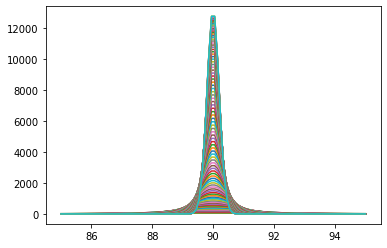

In [12]:
plt.pcolormesh(e_true, np.cos(zeniths), fit.extract()["eff_area"].squeeze().T,
              norm=LogNorm())
plt.colorbar()
plt.semilogx()
plt.figure()
_ =plt.plot(e_reco, np.exp(fit.extract()["e_res"].squeeze()))
plt.semilogx()

plt.figure()
_ =plt.plot(np.degrees(reco_zeniths), np.exp(fit.extract()["ang_res"].squeeze()).T)

In [13]:
ang_res_e = np.exp(fit.extract()["ang_res"].squeeze())
obs = hv.HoloMap({np.log10(e_true[i]): hv.Curve((np.degrees(reco_zeniths), ang_res_e[i])) for i in range(100)}, kdims='Energy')
obs

:HoloMap   [Energy]
   :Curve   [x]   (y)